# training_+ttbarModel.ipynb

This is code (in progress) for building and training the neural network.

## Imports

In [1]:
import sys
sys.path.append("/home/jchishol/TRecNet")
sys.path.append("home/jchishol/")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
from IPython.display import clear_output
# import keras_one_cycle_clr as ktool
import importlib
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

from training_utilities import PlotLearning


import normalize
import shape_timesteps
import analysis

## Loading Files

In [2]:
# Data type we want to use
data_type = 'variables_ttbar_ljets_6j_train'

# Dataset to train and test on
dataset = h5py.File('/mnt/xrootdg/jchishol/mntuples_08_01_22/'+data_type+'.h5','r')

# Numpy dictionary of [max,mean] for each variable
X_maxmean_dic = np.load('/home/jchishol/TRecNet/X_maxmean_'+data_type+'.npy',allow_pickle=True).item()
Y_maxmean_dic = np.load('/home/jchishol/TRecNet/Y_maxmean_'+data_type+'.npy',allow_pickle=True).item()

print(Y_maxmean_dic)

{'th_pt': [2424.3375, 146.26782280129046], 'th_px': [2362.653264314747, -0.3666419995242056], 'th_py': [1617.1234848701217, -0.7309517818436592], 'th_eta': [10.7022066116333, 0.0006546516046350356], 'th_m': [243.950390625, 172.24704438163957], 'wh_pt': [1530.4537, 99.08232], 'wh_px': [1458.7058, -0.16647542], 'wh_py': [1280.6017, -0.34663635], 'wh_eta': [8.925313, 0.00037031373], 'wh_m': [204.91702, 80.131836], 'tl_pt': [1753.741625, 149.8431497979587], 'tl_px': [1411.4162772061636, 0.4596621591353699], 'tl_py': [1749.8884470056903, 0.919522618382612], 'tl_eta': [10.510302543640137, -0.0007883497300055945], 'tl_m': [243.95125, 172.26423345769328], 'wl_pt': [1545.573, 104.85858], 'wl_px': [1412.5055, 0.41961476], 'wl_py': [1484.9803, 0.75195986], 'wl_eta': [9.102899, -0.0011327023], 'wl_m': [203.82205, 80.199715], 'ttbar_pt': [2474.3955, 86.34171], 'ttbar_px': [2381.875, 0.08814558], 'ttbar_py': [1938.1198, 0.18337932], 'ttbar_eta': [11.658719, 0.00018142884], 'ttbar_m': [4436.74, 542.3

## Useful Variables

In [3]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m','ttbar_pt','ttbar_eta','ttbar_phi','ttbar_m']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes

# Get the maxmean values we actually need for this particular model
xmm_keys = list(X_maxmean_dic.keys())
ymm_keys = [key for key in Y_maxmean_dic.keys() if 'isTruth' not in key]
X_maxmean = np.array([X_maxmean_dic[key] for key in xmm_keys])
Y_maxmean = np.array([Y_maxmean_dic[key] for key in ymm_keys])

print(crop0)

20490866


## Scale the Data

In [4]:
# Scales data set to be between -1 and 1, with a mean of 0
importlib.reload(normalize)    # Need to reload so it recognizes the variables we just defined
Scaler = normalize.Scale_variables(phi_keys,dataset,crop0)
X_total, X_names = Scaler.scale_arrays(dataset, X_keys, X_maxmean, crop0)
Y_total, Y_names = Scaler.scale_arrays(dataset, Y_keys, Y_maxmean, crop0)

## Split Data Into Training, Validation, and Testing

In [5]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
# Taking ~82% for training and ~18% for validation amounts to ~70% of total being training and ~15% of total being validation
split = 70/85   # Gave 85% to train file, now want 70% for the actual training

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(dataset, X_total, X_names, phi_keys, crop0, False,True)

# Split into training and validation data
trainX_jets, valX_jets, trainX_other, valX_other, trainY, valY = train_test_split(totalX_jets, totalX_other, Y_total, train_size=split)

print(trainY.shape)

(16874830, 25)


## Histograms of Scaled Input X and Y Variables

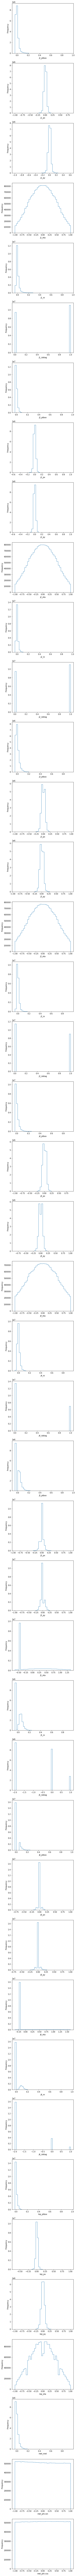

In [6]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

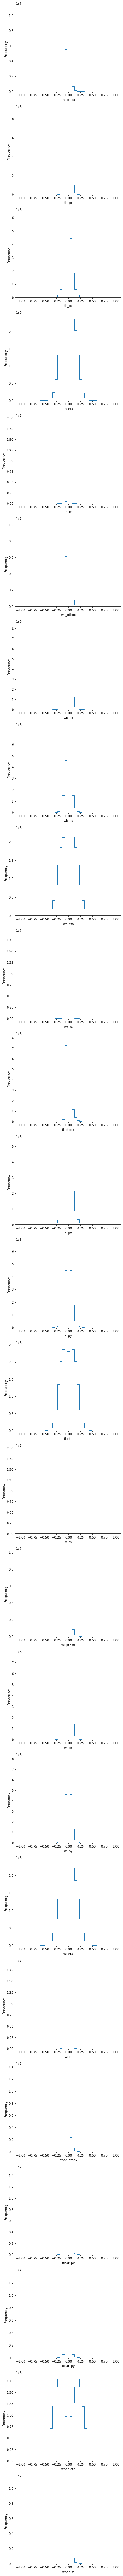

In [7]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

## Build the Model

In [8]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(256, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(10)(ldense2)   # 10 leptonic variable outputs
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(10+5)(hdense2)  # 10 hadronic variable outputs + 5 ttbar variable outputs
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    # Define loss function (do we even end up using this??)
    #def loss_fc(true, pred):
    #    return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

# Define loss function (again?)
#def loss_fc(true, pred):
#        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# Load or build model
#model = keras.models.load_model('new_model.keras', custom_objects={'loss_fc':loss_fc})
model = build_model()
model.summary()
#keras.utils.plot_model(model,to_file='Model_Custom+ttbar.png',show_shapes=True,show_dtype=True,show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 43)           0           ['input_2[0][0]',                
                                                                  'flatten[0][0]']            

2023-01-24 14:32:56.840609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-01-24 14:32:56.840658: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-24 14:32:56.841422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

## Fit the Model 

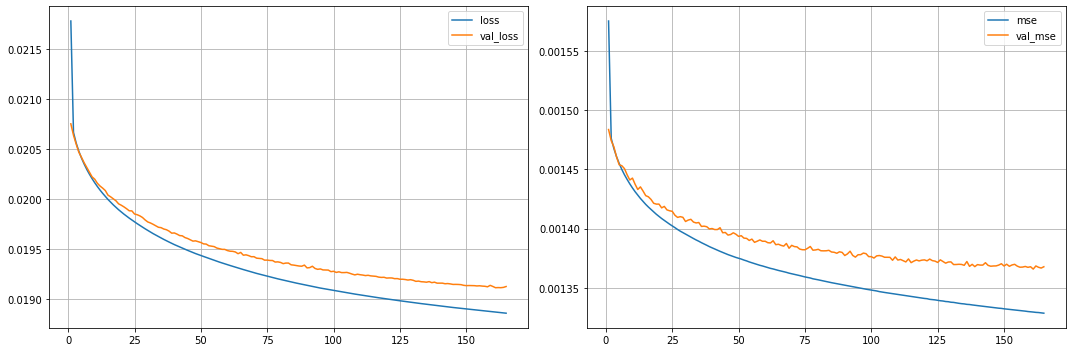

16875/16875 [==============================] - 275s 16ms/step - loss: 0.0189 - mse: 0.0013 - val_loss: 0.0191 - val_mse: 0.0014


In [9]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  # patience=4 means stop training after 4 epochs with no improvement
#clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999) # don't think we use?
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}

# Set number of epochs (runs through?)
Epochs= 256


# Fit the model (i.e. TRAIN the model)
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY), shuffle=True, callbacks=[early_stop,PlotLearning()],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)

## Save the Model

In [10]:
model.save('Model_Custom+ttbar_full_6j.keras')
np.save('trainHistory_Model_Custom+ttbar_full_6j.npy',history.history)

In [11]:
model = keras.models.load_model('Model_Custom+ttbar_full_take2.keras')
history = np.load('trainHistory_Model_Custom+ttbar_full_take2.npy',allow_pickle='TRUE').item()

## Plot Training Stats 

In [12]:
#plt.xlabel('Training Iterations')
#plt.ylabel('Learning Rate')
#plt.title("CLR - 'triangular' Policy")
#plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'TRecNet+ttbar MSE Loss')

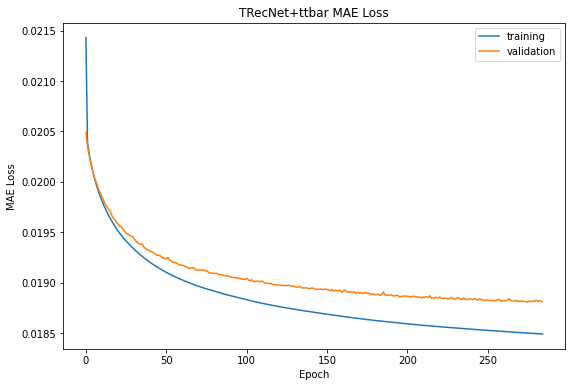

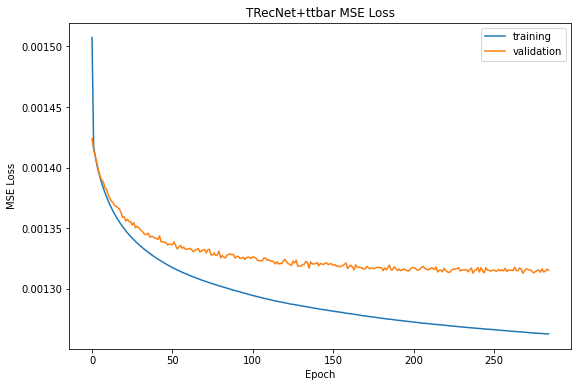

In [13]:
plt.figure(figsize=(9,6))
plt.plot(history['loss'], label='training')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.title('TRecNet+ttbar MAE Loss')

plt.figure(figsize=(9,6))
plt.plot(history['mse'], label='training')
plt.plot(history['val_mse'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('TRecNet+ttbar MSE Loss')



# Testing and Plots

This part of the code tests the machine learning and data.

## Make Predictions with Test Data

In [14]:
# Predict using un-scaled variables
predictions_unscaled = model.predict([valX_jets, valX_other])
true_unscaled = valY 

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

113002/113002 [==============================] - 453s 4ms/step


## Training Scale Plots (Tao's Code)

In [15]:
Analysis = analysis.Analysis
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0015444584829207419
 
th_ptbox MSE, MAE :  0.0003122271 0.0117678603
th_px MSE, MAE :  0.0005896891 0.0142089823
th_py MSE, MAE :  0.0012779910 0.0209626791
th_eta MSE, MAE :  0.0048222305 0.0392931333
th_m MSE, MAE :  0.0005977417 0.0087389592
wh_ptbox MSE, MAE :  0.0005977011 0.0152219540
wh_px MSE, MAE :  0.0009193028 0.0176280799
wh_py MSE, MAE :  0.0011965567 0.0201436489
wh_eta MSE, MAE :  0.0077362850 0.0540164235
wh_m MSE, MAE :  0.0008553565 0.0127717815
tl_ptbox MSE, MAE :  0.0004920404 0.0161390431
tl_px MSE, MAE :  0.0007988352 0.0187188873
tl_py MSE, MAE :  0.0006670927 0.0182232254
tl_eta MSE, MAE :  0.0028918000 0.0349547802
tl_m MSE, MAE :  0.0006062220 0.0087659110
wl_ptbox MSE, MAE :  0.0003417389 0.0138264686
wl_px MSE, MAE :  0.0002812319 0.0123784221
wl_py MSE, MAE :  0.0003457094 0.0143191168
wl_eta MSE, MAE :  0.0036868046 0.0426731432
wl_m MSE, MAE :  0.0008974409 0.0130678586
ttbar_ptbox MSE, MAE :  0.0002714957 0.0111285694
ttbar_px MSE, MAE :  0.

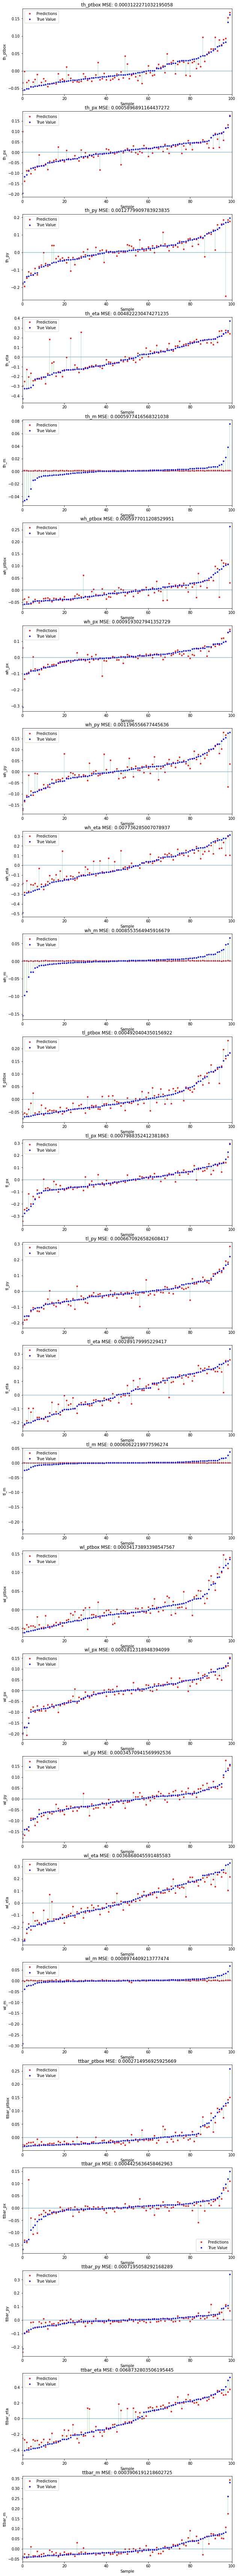

In [16]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)  # I think this is plotting the first 100 events? As like a sample

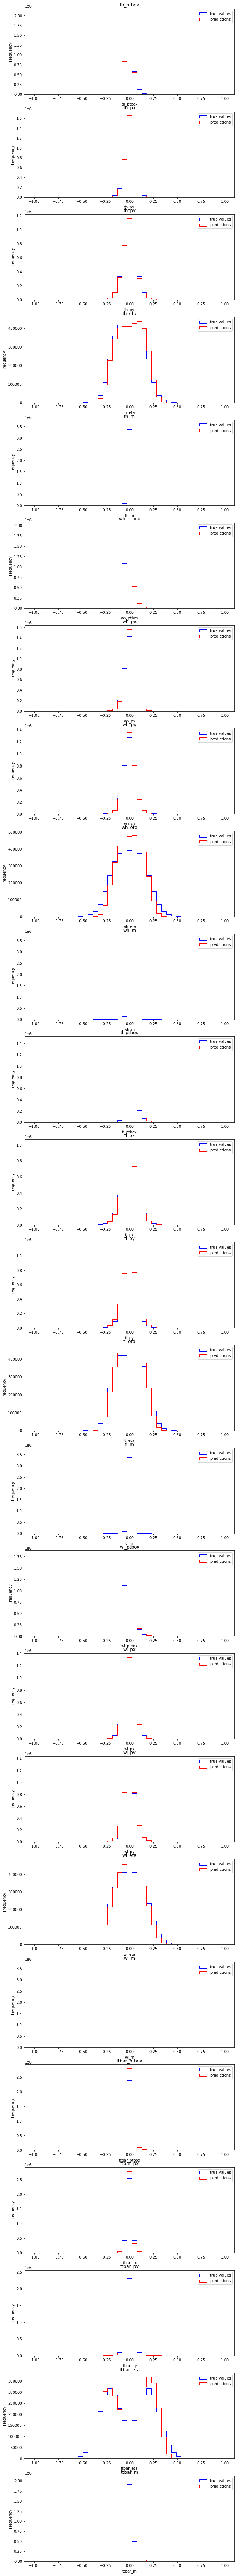

In [17]:
# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

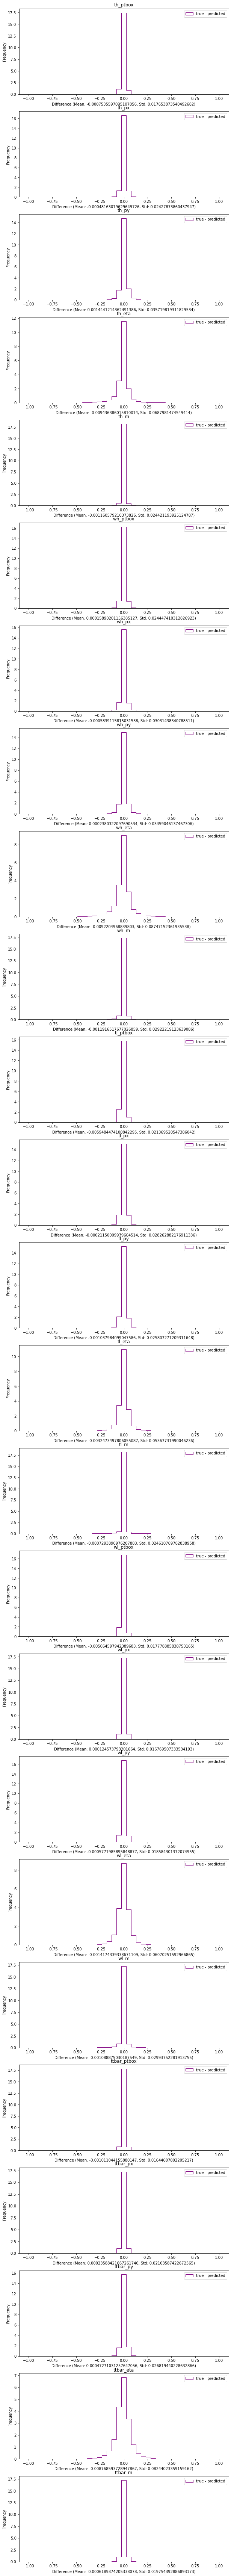

In [18]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

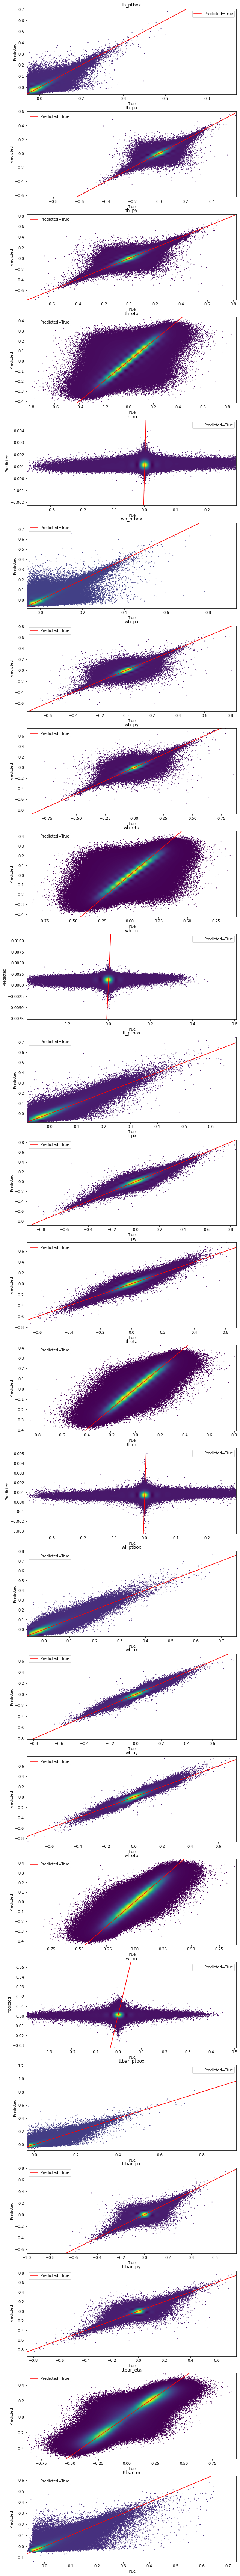

In [19]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

## Original Scale Plots

In [20]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 753.7552057499843
 
th_pt MSE, MAE :  1835.0874211976 28.5292649716
th_eta MSE, MAE :  0.5523249034 0.4205232310
th_phi MSE, MAE :  0.6857787044 0.4483338660
th_m MSE, MAE :  35.5726778003 2.1318725008
wh_pt MSE, MAE :  1399.9885431292 23.2964964058
wh_eta MSE, MAE :  0.6162818406 0.4821134865
wh_phi MSE, MAE :  0.6682349102 0.4579611728
wh_m MSE, MAE :  35.9172627556 2.6171554492
tl_pt MSE, MAE :  1513.3243284567 28.3037116035
tl_eta MSE, MAE :  0.3194469025 0.3673853151
tl_phi MSE, MAE :  0.4156891075 0.3470846578
tl_m MSE, MAE :  36.0776122780 2.1384549491
wl_pt MSE, MAE :  816.3445617406 21.3698164991
wl_eta MSE, MAE :  0.3054988120 0.3884492955
wl_phi MSE, MAE :  0.2034136088 0.2655410057
wl_m MSE, MAE :  37.2827730933 2.6635177513
ttbar_pt MSE, MAE :  1662.2685218705 27.5364821277
ttbar_eta MSE, MAE :  0.9342556504 0.6753747696
ttbar_phi MSE, MAE :  1.3014604452 0.7940343098
ttbar_m MSE, MAE :  7689.2061295927 55.2784940158


In [21]:
importlib.reload(analysis)
analysis.Analysis.save_errors(predictions_origscale,true_origscale,Y_keys,True,'Model_Custom+ttbar_Errors')

In [22]:
e = np.load('Model_Custom+ttbar_Errors.npy',allow_pickle=True).item()
print(e)

{'th_pt': {'mse': 1835.0874211975997, 'mae': 28.529264971555747}, 'th_eta': {'mse': 0.5523249033824724, 'mae': 0.4205232310488996}, 'th_phi': {'mse': 0.685778704447195, 'mae': 0.44833386596636404}, 'th_m': {'mse': 35.57267780032883, 'mae': 2.131872500782787}, 'wh_pt': {'mse': 1399.9885431292444, 'mae': 23.296496405848895}, 'wh_eta': {'mse': 0.6162818406213366, 'mae': 0.48211348649625935}, 'wh_phi': {'mse': 0.6682349102292339, 'mae': 0.457961172823943}, 'wh_m': {'mse': 35.917262755615155, 'mae': 2.617155449164188}, 'tl_pt': {'mse': 1513.3243284567238, 'mae': 28.303711603490843}, 'tl_eta': {'mse': 0.3194469024823839, 'mae': 0.3673853151230437}, 'tl_phi': {'mse': 0.4156891075127928, 'mae': 0.3470846577826194}, 'tl_m': {'mse': 36.07761227801496, 'mae': 2.1384549490597093}, 'wl_pt': {'mse': 816.3445617406164, 'mae': 21.36981649909169}, 'wl_eta': {'mse': 0.3054988119708216, 'mae': 0.38844929548330037}, 'wl_phi': {'mse': 0.20341360875016307, 'mae': 0.26554100568431904}, 'wl_m': {'mse': 37.282

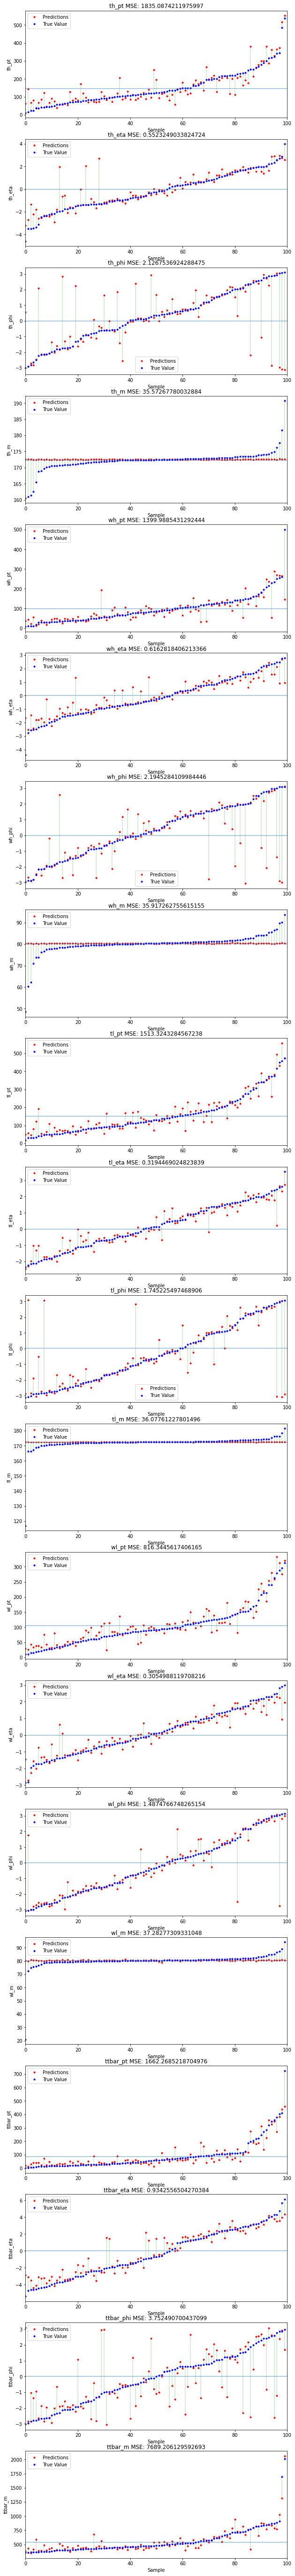

In [23]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

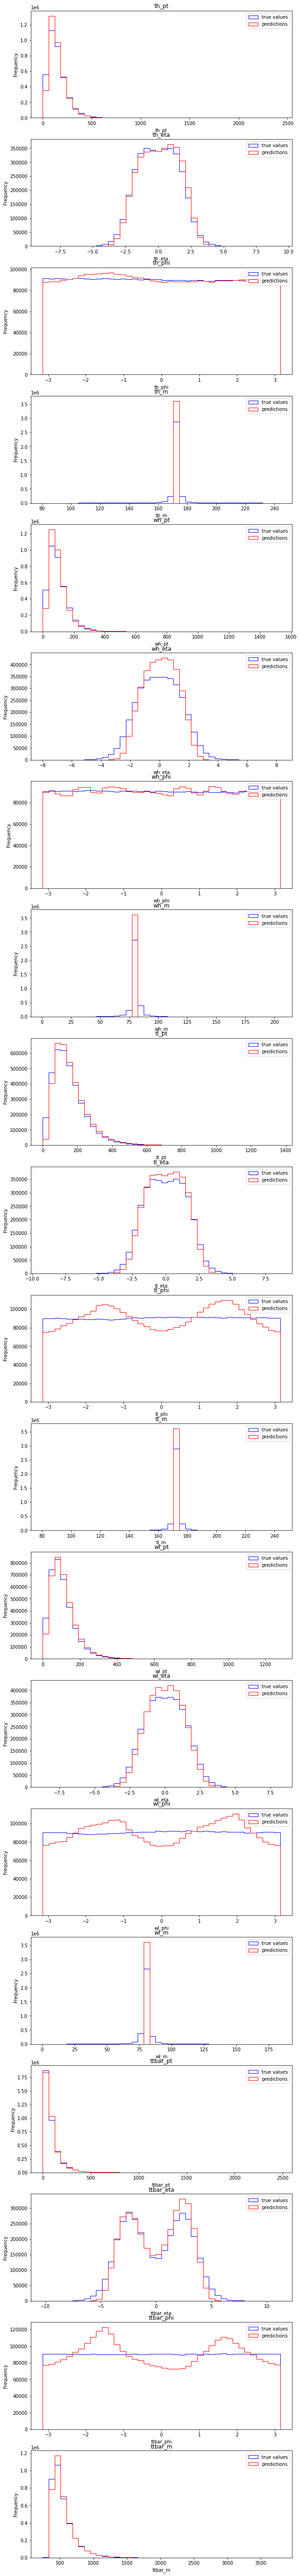

In [24]:
importlib.reload(analysis)
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

/home/jchishol/myVenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


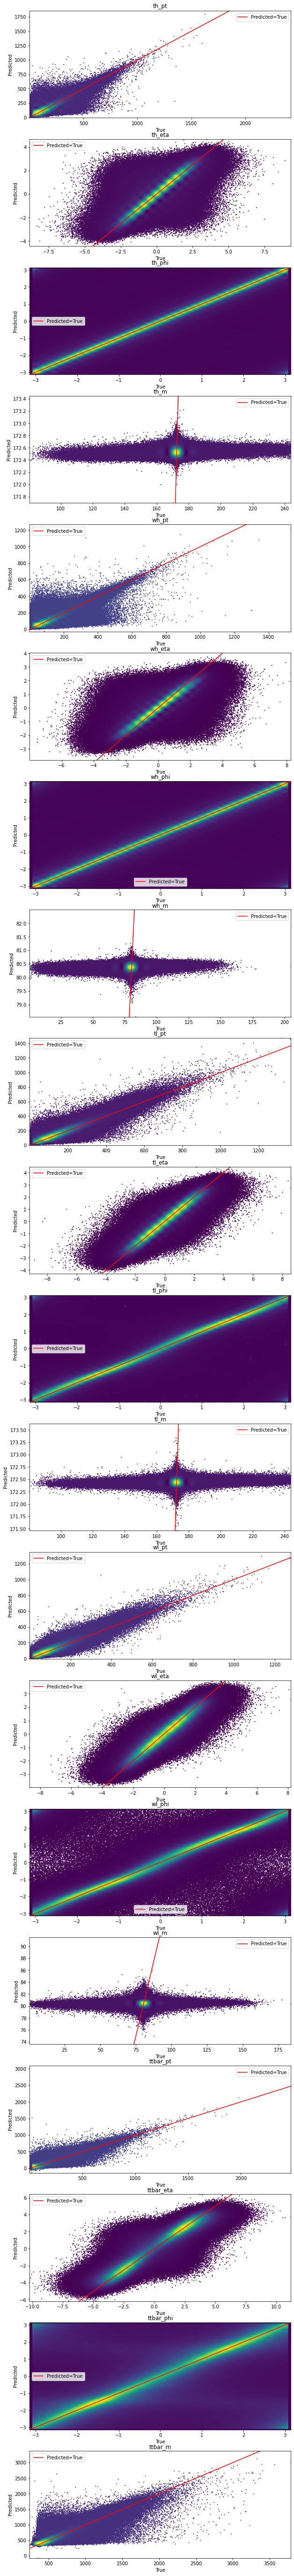

In [25]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

## Observables

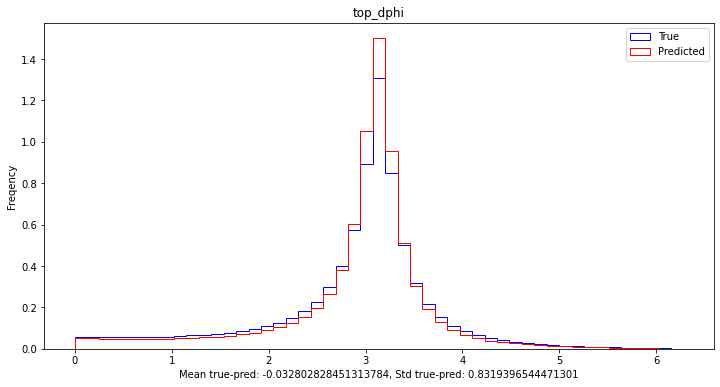

In [26]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

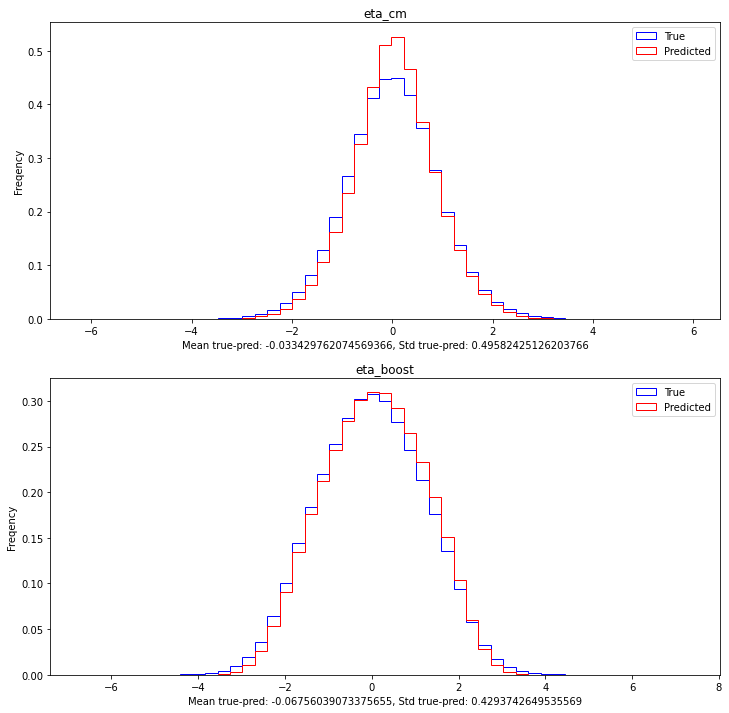

In [27]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])

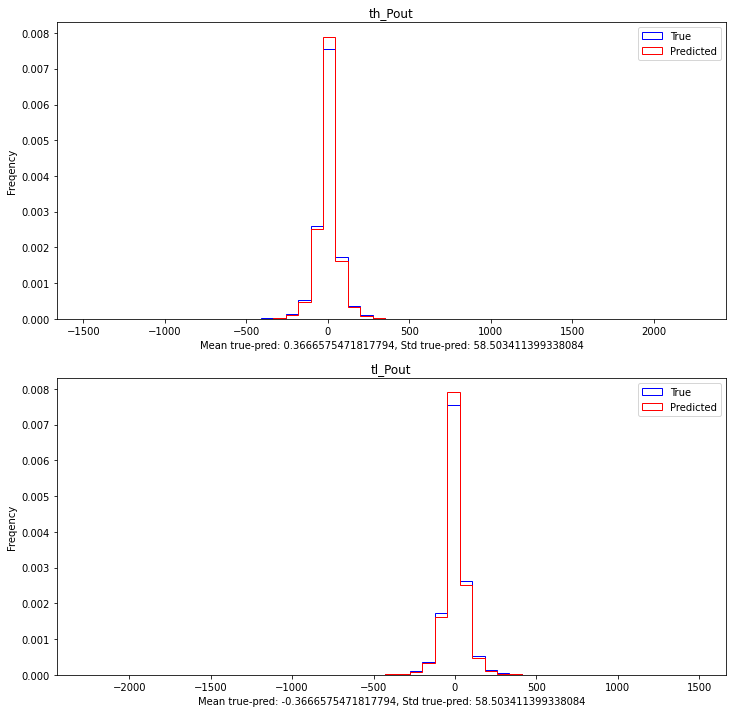

In [28]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

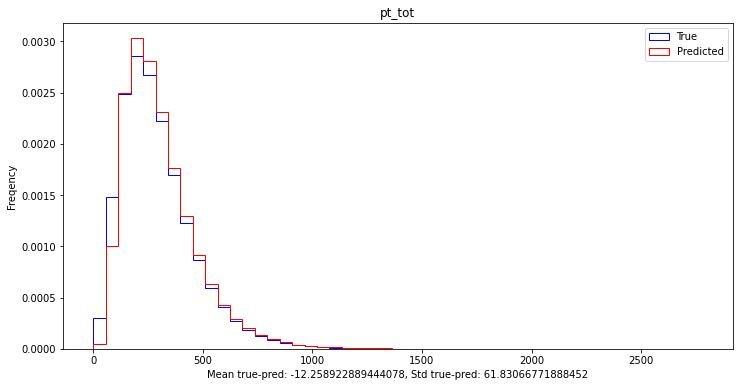

In [29]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])